# Monitoramento de casos de CVID19 no Brasil.

**Este notebook tem como objetivo aplicar técnicas de análise da dados, somente para fins didáticos.**

### INFORMAÇÕES SOBRE AS BASES UTILIZADAS

* Base utilizada para extrair dados do Brasil e Estados [G1  Globo](https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/27/casos-de-coronavirus-no-brasil-em-27-de-marco.ghtml) Fonte: Ministério da Saúde até 15 de março; secretarias estaduais da Saúde a partir de 16 de março.Criado com Datawrapper

* Base utilizada para extrair dados dos Municipios [brasil.io](https://brasil.io/dataset/covid19/caso) Boletins informativos baseado no Ministério da Saúde e secretarias estaduais da Saúde.

* Base utilizada para extrair dados dos Mundial  [BNO News]( https://bnonews.com/index.php/2020/03/the-latest-coronavirus-cases ) Boletins informativos baseado nos dados da OMS.

* Base utilizada para extrair dados dos Mundial [OMS]( https://who.sprinklr.com)OMS.

* Base utilizada para extrair dados dos Estados [Ministério da Saúde]( https://covid.saude.gov.br/ )

*Nenhuma copia deste notebook é permitida sem citar a fonte original.*

In [1]:
#!pip install matplotlib

In [2]:
from jupyterthemes import jtplot as jt
import pandas as pd
import numpy as np
import cufflinks as cf
import wget
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import folium
from folium.plugins import Search
import os
from branca.element import Template, MacroElement
import requests
import json
from pandas.io.json import json_normalize
from folium import plugins
from numpy import nan as NA
from plotly.offline import iplot
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
cf.go_offline()
plotly.offline.init_notebook_mode(connected=True)


## Carregamento e Tratamento dos Dados

In [20]:

################################downloads######################################################### 
url_brasil_io = 'https://brasil.io/dataset/covid19/caso?format=csv'
if os.path.exists('DB/api_br_io.csv'):
    os.remove('DB/api_br_io.csv')
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
else:
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
################################################################################################### 
#A URL muda diariamente 
url_ministerio_saude = ('https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/40a3afe95b5cc9e252c46e9b9fcb3c78_Download_COVID19_20200506.csv')
if os.path.exists('DB/ministerio_saude.csv'):
    os.remove('DB/ministerio_saude.csv')
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')
else:
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')



100% [..............................................................................] 87102 / 87102

In [21]:
###############################read_csv######################################################### 
estados = pd.read_csv('DB/estados.csv', encoding='utf-8')
municipios = pd.read_csv('DB/municipios.csv', encoding='utf-8')
api_br_io = pd.read_csv('DB/api_br_io.csv')
api_br_io = api_br_io.fillna(0)
api_br_io.city_ibge_code = api_br_io.city_ibge_code.astype('int64')
url_estados = 'DB/estados.json'
cidades = pd.read_json(url_estados)
municipios_map = json_normalize(cidades.features)  
casos = pd.read_csv('DB/ministerio_saude.csv', sep=';', encoding='cp1252')

########################################################################

C:\Users\joner\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [22]:
#renomeando colunas
municipios.columns = ['city_ibge_code','city','latitude','longitude','capital','uf_code']
casos.columns = ['regiao','sigla','data','casosNovos','casosAcumulados','obitosNovos','obitosAcumulados']

#tratando nomes para fazer o merge
estados = estados[['uf', 'nome']]
estados.columns = ['state','state_name']
cidades = api_br_io.merge(municipios.drop('uf_code', axis=1), on=['city','city_ibge_code'], how='left')
cidades = cidades.merge(estados, on='state', how='left')

cidades = cidades[(cidades.is_last==True) & (cidades.city !='Importados/Indefinidos')]
dadosCidades = cidades[ cidades.latitude.notnull() ]
cidades = dadosCidades[dadosCidades.place_type == 'city']
estados_brasil = dadosCidades[dadosCidades.capital == 1.0]
saude = pd.DataFrame(casos)


### Criando dados gerais do Brasil

In [23]:
dados = saude.copy()
dadoslimpo = dados.dropna()
dadoslimpo['casosNovos'] = pd.to_numeric(dadoslimpo['casosNovos'])
dadoslimpo['obitosNovos'] = pd.to_numeric(dadoslimpo['obitosNovos'])
dadoslimpo['casosAcumulados'] = pd.to_numeric(dadoslimpo['casosAcumulados'])
dadoslimpo['obitosAcumulados'] = pd.to_numeric(dadoslimpo['obitosAcumulados'])
#dadoslimpo['data'] = pd.to_datetime(dadoslimpo['data'], format='%d-%m-%Y')

casosNovosDia = dadoslimpo['casosNovos'].groupby(dadoslimpo['data']).sum()
casosNovosDia = casosNovosDia[(casosNovosDia.index >= '2020-02-26')].reset_index()

obitosNovosDia = dadoslimpo['obitosNovos'].groupby(dadoslimpo['data']).sum()
obitosNovosDia = obitosNovosDia[(obitosNovosDia.index >= '2020-02-26')].reset_index()

casosNovos = dadoslimpo['casosNovos'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
casosNovos = casosNovos[casosNovos>=0].reset_index().drop('data',axis=1)

obitosNovos = dadoslimpo['obitosNovos'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
obitosNovos = obitosNovos[obitosNovos>=0].reset_index().drop('data',axis=1)

mortesTotal = dadoslimpo['obitosAcumulados'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
mortesTotal = mortesTotal[(mortesTotal.index >= '2020-02-26')].reset_index()

casosTotal = dadoslimpo['casosAcumulados'].groupby(dadoslimpo['data']).sum().sort_values(ascending=True)
casosTotal = casosTotal[(casosTotal.index >= '2020-02-26')].reset_index()


In [24]:
teste = dadoslimpo[['casosAcumulados','data']].groupby(dadoslimpo['data']).sum()


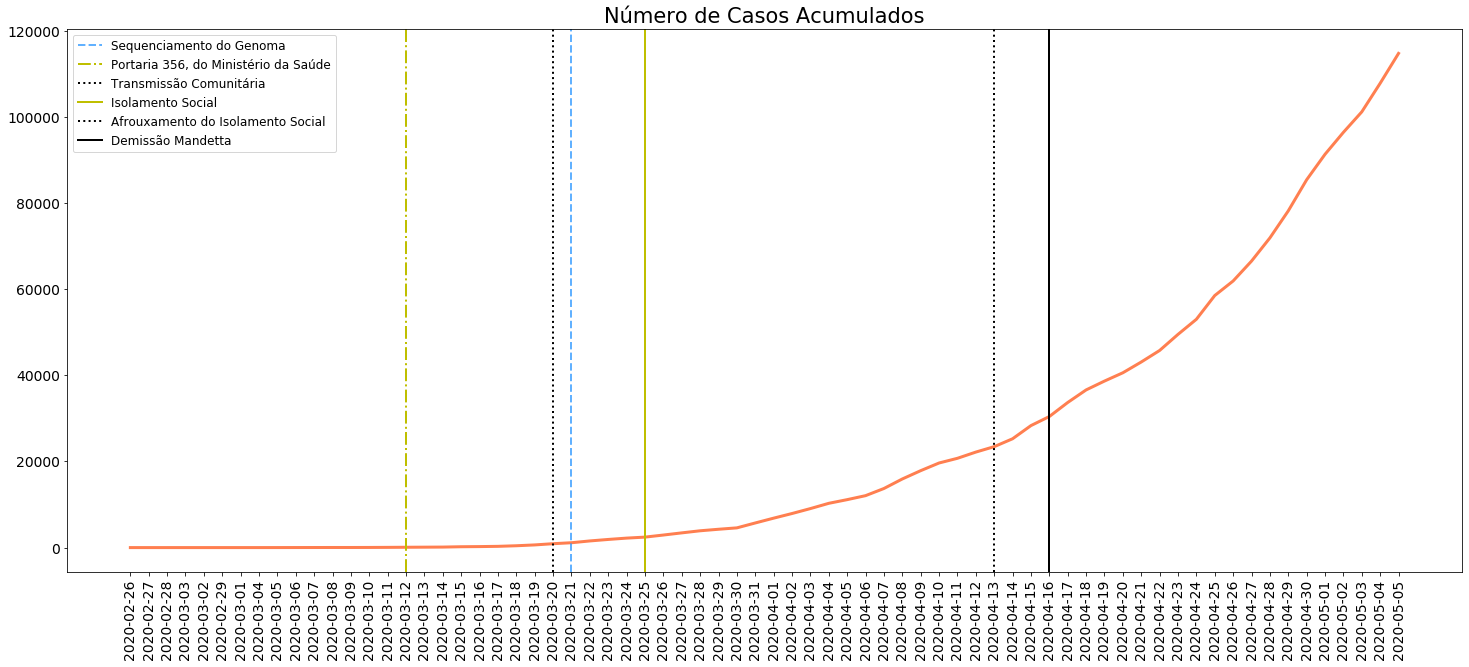

In [8]:

plt.figure(figsize=(25, 10))
plt.plot(casosTotal.data, casosTotal['casosAcumulados'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(casosTotal.data, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Número de Casos Acumulados', fontsize=21)

plt.axvline('2020-03-21', 0, 8000, color='dodgerblue', linestyle='--', linewidth=2, alpha=0.7, label='Sequenciamento do Genoma')
plt.axvline('2020-03-12', 0, 8000, color='y', linestyle='-.', linewidth=2, alpha=1, label='Portaria 356, do Ministério da Saúde')
plt.axvline('2020-03-20', 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Transmissão Comunitária')
plt.axvline('2020-03-25', 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Isolamento Social')
plt.axvline('2020-04-13', 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline('2020-04-16', 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

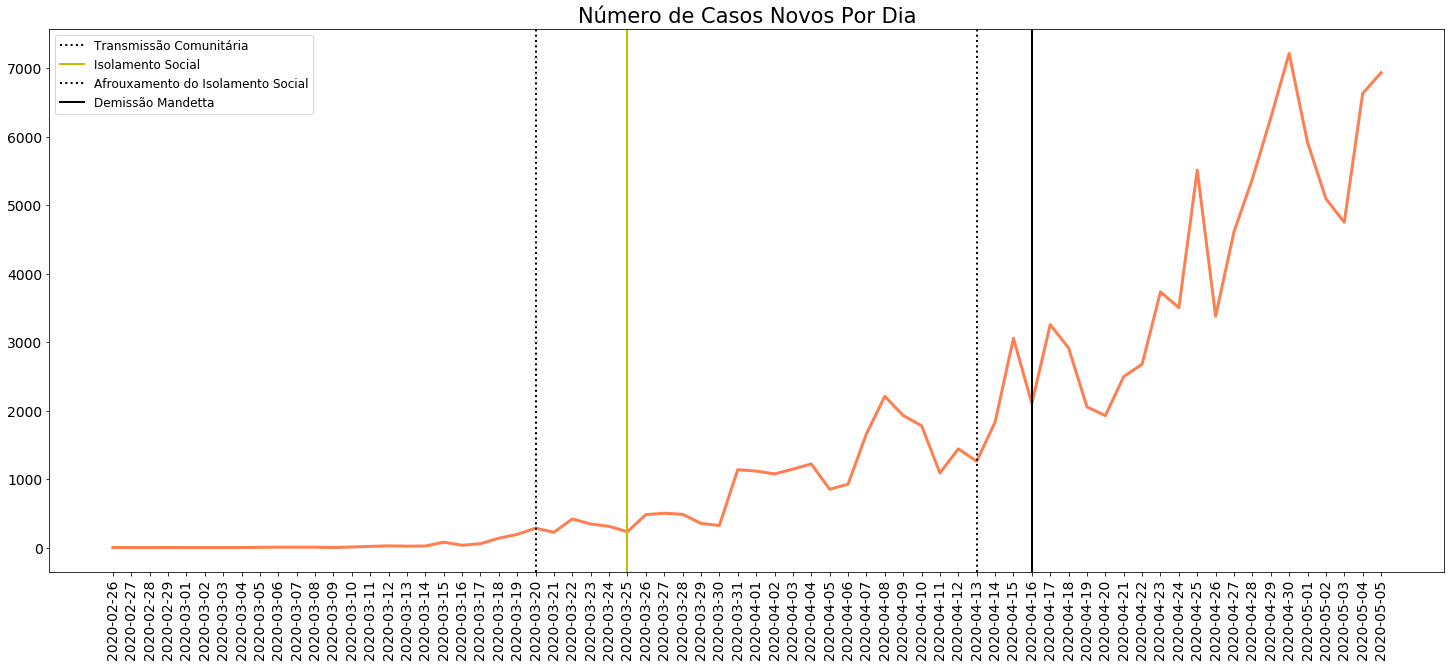

In [9]:
plt.figure(figsize=(25, 10))
plt.plot(casosNovosDia.data, casosNovosDia['casosNovos'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(casosNovosDia.data, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
#plt.axvline('2020-03-21', 0, 8000, color='dodgerblue', linestyle='--', linewidth=2, alpha=0.7, label='Sequenciamento do Genoma')
#plt.axvline('2020-03-12', 0, 8000, color='y', linestyle='-.', linewidth=2, alpha=1, label='Portaria 356, do Ministério da Saúde')
plt.axvline('2020-03-20', 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Transmissão Comunitária')
plt.axvline('2020-03-25', 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Isolamento Social')
plt.axvline('2020-04-13', 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline('2020-04-16', 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
plt.title('Número de Casos Novos Por Dia', fontsize=21) 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

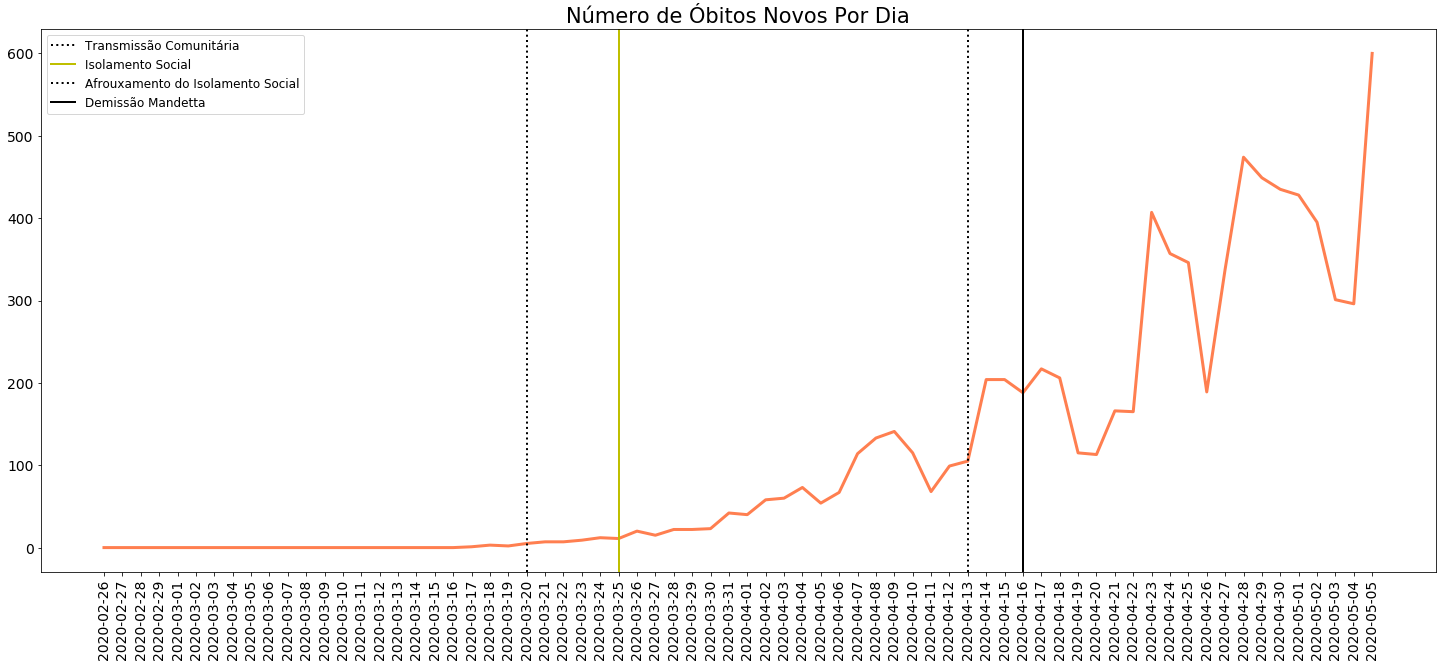

In [10]:
plt.figure(figsize=(25, 10))
plt.plot(obitosNovosDia.data, obitosNovosDia['obitosNovos'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(obitosNovosDia.data, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
#plt.axvline('2020-03-21', 0, 8000, color='dodgerblue', linestyle='--', linewidth=2, alpha=0.7, label='Sequenciamento do Genoma')
#plt.axvline('2020-03-12', 0, 8000, color='y', linestyle='-.', linewidth=2, alpha=1, label='Portaria 356, do Ministério da Saúde')
plt.axvline('2020-03-20', 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Transmissão Comunitária')
plt.axvline('2020-03-25', 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Isolamento Social')
plt.axvline('2020-04-13', 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline('2020-04-16', 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
plt.title('Número de Óbitos Novos Por Dia', fontsize=21) 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

# Gráficos Brasil

In [11]:
from datetime import datetime
now = datetime.now()
fig1 = go.Figure(
    [
        go.Scatter(x = casosTotal.data, y = casosTotal['casosAcumulados'], mode = 'markers+lines', name="Casos acumulados"),
        go.Scatter(x = mortesTotal.data, y = mortesTotal['obitosAcumulados'], mode = 'markers+lines', name="Óbitos acumulados"),
    ]
)
config = {'displayModeBar': True}
fig1.update_layout(title='Confirmados Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white",
annotations=[
        dict(
            x=str(now.year)+'-'+str(now.month)+'-'+str(now.day-1),
            y=casosTotal.casosAcumulados.max(),
            xref="x",
            yref="y",
            text=casosTotal.casosAcumulados.max(),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=str(now.year)+'-'+str(now.month)+'-'+str(now.day-1),
            y=mortesTotal.obitosAcumulados.max(),
            xref="x",
            yref="y",
            text=mortesTotal.obitosAcumulados.max(),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        )]
)


fig1.show()
plotly.offline.plot(fig1, filename='HTML/AcumuladoBrasilDia.html', auto_open=False)

'HTML/AcumuladoBrasilDia.html'

In [12]:
obitosNovos['obitosNovos'].sum()

7921

In [13]:
fig = go.Figure(
    [
        go.Scatter(x = dados.data, y = casosNovos['casosNovos'], mode = 'markers+lines', name="Casos novos por dia"),
        go.Scatter(x = dados.data, y = obitosNovos['obitosNovos'], mode = 'markers+lines', name="Óbitos novos por dia"),
       
    ]
)


fig.update_layout(title='Casos e Óbitos Acumulado Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white")

fig.show()
plotly.offline.plot(fig, filename='HTML/NovosCasosObitosAcumuladoBrasilDia.html', auto_open=False)

'HTML/NovosCasosObitosAcumuladoBrasilDia.html'

In [14]:
from datetime import datetime
now = datetime.now()
fig2 = go.Figure()
    
fig2.add_trace(go.Scatter(x = casosNovosDia.data, y = casosNovosDia['casosNovos'], name="Casos novos por dia",fill='tonexty'))


fig2.update_layout(title='Casos Novos Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white",
)

fig2.show()
plotly.offline.plot(fig2, filename='HTML/NovosCasosBrasilDia.html', auto_open=False)

'HTML/NovosCasosBrasilDia.html'

In [15]:
import cufflinks as cf



fig = casosNovosDia.casosNovos.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True
                                   
)
#fig = casosTotal.casosAcumulados.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True)
#fig = mortesTotal.obitosAcumulados.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True)
fig.show()

In [16]:
fig = px.line(dadoslimpo, x='data', y='casosAcumulados',color="sigla",line_group="sigla", hover_name="sigla" , text='obitosAcumulados')
fig.update_layout(title='Casos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/CasosAcumuladoEstadosDia.html', auto_open=False)

'HTML/CasosAcumuladoEstadosDia.html'

In [17]:

fig = px.line(dadoslimpo, x='data', y='obitosAcumulados',color="sigla",line_group="sigla", hover_name="sigla", text='obitosAcumulados')
fig.update_layout(title='Óbitos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/ObitosAcumuladoEstadosDia.html', auto_open=False)

'HTML/ObitosAcumuladoEstadosDia.html'

In [18]:

trace = go.Pie(labels = list(dadoslimpo.regiao),
               values = list(dadoslimpo.casosNovos),
               textinfo='percent+value'
              )

# Armazenando gráfico em uma lista:
casos = [trace]

# Criando Layout:
layout = go.Layout(title='Porcentagem de casos confirmados por Região')

# Criando figura que será exibida:
fig3 = go.Figure(data=casos, layout=layout)

py.iplot(fig3)
plotly.offline.plot(fig3, filename='HTML/PercentualAcumuladoRegiaoDia.html', auto_open=False)

'HTML/PercentualAcumuladoRegiaoDia.html'

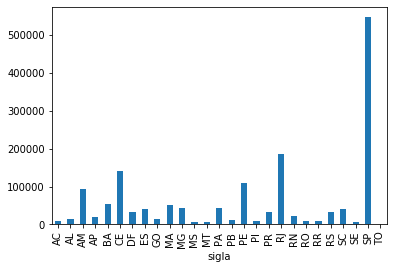

In [19]:
estados =dados.groupby('sigla')
acumuladodia= estados.casosAcumulados.sum()
acumuladodia.plot(kind='bar')

In [20]:
#api_br_io[ (api_br_io.state == 'RS')]

In [21]:
dataRS =api_br_io[ api_br_io.city.notnull() ]
rs = dataRS [ (dataRS.state == 'RS')&(dataRS.date == '2020-05-06') & (dataRS.place_type =='city')].sort_values(by='confirmed',ascending=False)
rs.groupby(['city'] )
rs.fillna(0, inplace = True)
fig = go.Figure(data=[go.Table(
    header=dict(values=['Cidades  % '+ str(round(rs.city.size*100/497,2)) +'<br><b>Total--</b>'+str(rs.city.size) +'</br>' ,
                        '<br>Confirmados</br> <b>Total-</b>'+ str(rs.confirmed.sum()),
                        '<br>Mortes</br>  <b>Total-</b>'+ str(rs.deaths.sum().astype(int))],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[rs.city, rs.confirmed,rs.deaths],
               fill_color='lavender',
               align='left'))
])

fig.show()
plotly.offline.plot(fig, filename='HTML/TabelaCovid19RS.html', auto_open=False)

'HTML/TabelaCovid19RS.html'

In [22]:
#![Tabela1 casos confirmados por cidades do RS](IMG/Alegrete.jpg)

In [23]:
import plotly.express as px


fig = px.bar(rs.head(10), y='city', x='confirmed',color='deaths', text='confirmed',orientation='h')

fig.update_traces( textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [24]:
#![Figura4 Acumulado dos casos no RS e óbitos](IMG/RS.jpg)

In [25]:
import codecs
br_estados = 'DB/br_states.json'
geo_json_estados = json.load(codecs.open(br_estados, 'r', 'utf-8'))
br_municipios= 'DB/br_states2.json'
geo_json_municipios = json.load(codecs.open(br_municipios, 'r', 'cp1252'))
covid_cidades= cidades.copy()
covid_estados= estados_brasil.copy()
df_bsb =covid_cidades[( covid_cidades.city.notnull()) & (covid_cidades.place_type =='city') ]
#df_estados =covid_estados[( covid_estados.city.notnull()) & (covid_estados.place_type =='city')& (covid_estados.state =='RS') ]
teste = cidades[['state','confirmed','deaths','death_rate']].groupby(cidades['state']).sum()
df_estados = estados_brasil.drop(['capital'], axis=1 ).merge(teste, on='state')
df_bsb['date'] = df_bsb['date'].apply(lambda x: pd.Timestamp(x).strftime('%d-%m-%Y'))

#cidades_captais= cidades[cidades.capital==1][['state','latitude','longitude','confirmed']]
#df_estados = estados_brasil.drop(['latitude','longitude', 'capital'], axis=1 ).merge(cidades_captais, on='state')
df_bsb

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,latitude,longitude,capital,state_name
0,06-05-2020,AC,Acrelândia,city,15,1,True,15256.0,1200013,98.32197,0.0667,-9.82581,-66.8972,0.0,Acre
1,06-05-2020,AC,Assis Brasil,city,1,0,True,7417.0,1200054,13.48254,0.0000,-10.92980,-69.5738,0.0,Acre
2,06-05-2020,AC,Bujari,city,3,0,True,10266.0,1200138,29.22268,0.0000,-9.81528,-67.9550,0.0,Acre
3,06-05-2020,AC,Cruzeiro do Sul,city,26,0,True,88376.0,1200203,29.41975,0.0000,-7.62762,-72.6756,0.0,Acre
4,06-05-2020,AC,Feijó,city,1,0,True,34780.0,1200302,2.87522,0.0000,-8.17054,-70.3510,0.0,Acre
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4818,05-05-2020,TO,Sampaio,city,1,0,True,4711.0,1718808,21.22692,0.0000,-5.35423,-47.8782,0.0,Tocantins
4819,05-05-2020,TO,São Miguel do Tocantins,city,18,0,True,12139.0,1720200,148.28240,0.0000,-5.56305,-47.5743,0.0,Tocantins
4820,05-05-2020,TO,Sítio Novo do Tocantins,city,3,1,True,9029.0,1720804,33.22627,0.3333,-5.60120,-47.6381,0.0,Tocantins
4822,05-05-2020,TO,Tocantinópolis,city,2,0,True,22870.0,1721208,8.74508,0.0000,-6.32447,-47.4224,0.0,Tocantins


In [26]:
from folium.plugins import MarkerCluster

# Mapa do Brasil municípios com COVID-19

In [27]:

#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)
#Malha territorial Estados
statesgeo = folium.GeoJson(
    geo_json_estados, name='Estados',
    style_function=lambda feature: { 
      'fillOpacity': 0.9,
        'weight': 0.1,
        'fillColor': 'white'
    }

).add_to(brasil)
#Controlador de Camadas
fg1=folium.FeatureGroup(name='De 1 a 50', show=True)
brasil.add_child(fg1)
fg2=folium.FeatureGroup(name='De 50 a 100', show=True)
brasil.add_child(fg2)
fg3=folium.FeatureGroup(name='De 100 a 1000', show=True)
brasil.add_child(fg3)
fg4=folium.FeatureGroup(name='Acima de 1000', show=True)
brasil.add_child(fg4)


#Add legenda
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>COVID-19 Brasil</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Nº de Casos</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>De 1 a 50</li>
    <li><span style='background:yellow;opacity:0.7;'></span>De 50 a 100</li>
    <li><span style='background:red;opacity:0.7;'></span>De 100 a 1000</li>
    <li><span style='background:black;opacity:0.7;'></span>Acima de 1000</li>
  </ul>
   <p>
     Fonte: Brasil.io,IBGE.
     </p>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

brasil.get_root().add_child(macro)


#percorre o Df 
for _, dados in df_bsb.iterrows():
    
    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str("{0:.2%}".format(dados.death_rate)) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """

    if (dados['confirmed']>=1) & (dados['confirmed']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=10000,
        color='green',
        stroke= False,
        fill=True,
        fill_color='green',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg1)


    if (dados['confirmed']>=50) & ( dados['confirmed']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='yellow',
        stroke= False,
        fill=True,
        fill_color='yellow',
        opacity=0.6,
        fill_opacity=0.6
        #Stroke_opacity=70
        ).add_to(fg2)
 
    if ((dados['confirmed']>=100) & ( dados['confirmed']<1000)):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='red',
        stroke= False,
        fill=True,
        fill_color='red',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg3)
        
    if (dados['confirmed']>=1000):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=50000,
        color='black',
        stroke= False,
        fill=True,
        fill_color='black',
        opacity=0.7,
        fill_opacity=0.7
        #Stroke_opacity=70
        ).add_to(fg4)
"""
stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
 """ 
#add busca por estado
statesearch = Search(
    layer=statesgeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)


folium.LayerControl().add_to(brasil)
brasil.save('HTML/MapaBrasilCovid19.html')


# Mapa do Brasil Estados com COVID-19

In [28]:
#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))

brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)
#Malha territorial Estados
statesgeo = folium.GeoJson(
    geo_json_estados, name='Estados',
    style_function=lambda feature: { 
      'fillOpacity': 0.9,
        'weight': 0.1,
        'fillColor': 'white'
    }

).add_to(brasil)
#Controlador de Camadas
fg1=folium.FeatureGroup(name='De 1 a 50', show=True)
brasil.add_child(fg1)
fg2=folium.FeatureGroup(name='De 50 a 100', show=True)
brasil.add_child(fg2)
fg3=folium.FeatureGroup(name='De 100 a 1000', show=True)
brasil.add_child(fg3)
fg4=folium.FeatureGroup(name='Acima de 1000', show=True)
brasil.add_child(fg4)


#Add legenda
template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>COVID-19 Brasil</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Nº de Casos</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:green;opacity:0.7;'></span>De 1 a 50</li>
    <li><span style='background:yellow;opacity:0.7;'></span>De 50 a 100</li>
    <li><span style='background:red;opacity:0.7;'></span>De 100 a 1000</li>
    <li><span style='background:black;opacity:0.7;'></span>Acima de 1000</li>
     <p>
     Fonte: Brasil.io,IBGE.
     </p>
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

macro = MacroElement()
macro._template = Template(template)

brasil.get_root().add_child(macro)


#percorre o Df 
for _, dados in df_estados.iterrows():
    
    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed_y) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths_y) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str("{0:.2f}".format(dados.death_rate_y)) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """

    if (dados['confirmed_y']>=1) & (dados['confirmed_y']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed_y']*10,
        color='green',
        stroke= False,
        fill=True,
        fill_color='green',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg1)


    if (dados['confirmed_y']>=50) & ( dados['confirmed_y']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed_y']*10,
        color='yellow',
        stroke= False,
        fill=True,
        fill_color='yellow',
        opacity=0.6,
        fill_opacity=0.6
        #Stroke_opacity=70
        ).add_to(fg2)
 
    if ((dados['confirmed_y']>=100) & ( dados['confirmed_y']<1000)):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed_y']*10,
        color='red',
        stroke= False,
        fill=True,
        fill_color='red',
        opacity=0.5,
        fill_opacity=0.5
        #Stroke_opacity=70
        ).add_to(fg3)
        
    if (dados['confirmed_y']>=1000):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed_y']*10,
        color='black',
        stroke= False,
        fill=True,
        fill_color='black',
        opacity=0.7,
        fill_opacity=0.7
        #Stroke_opacity=70
        ).add_to(fg4)
"""
stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
 """ 
#add busca por estado
statesearch = Search(
    layer=statesgeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)


folium.LayerControl().add_to(brasil)

brasil.save('HTML/MapaBrasilEstadosCovid19.html')

In [29]:
#![Figura6 casos no RS ](IMG/RScasosDISTRI.jpg)

In [30]:
from datetime import datetime
now = datetime.now()

In [31]:
#hack ministério da saéde
print (str(now.year)+str(now.month)+str(now.day))



202057


In [32]:
from folium.plugins import MarkerCluster


m = folium.Map(location=[-15.77972, -47.92972], zoom_start=4)
marker_cluster = MarkerCluster().add_to(m)


for _, dados in df_estados.iterrows():

    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed_y) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths_y) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str("{0:.2%}".format(dados.death_rate_y)) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """  
    
    folium.Marker(
        
        location=[dados['latitude'], dados['longitude']],
        popup=html,
        icon=folium.Icon(color='green', icon='ok-sign'),
        clustered_marker = True,
).add_to(marker_cluster)



m.save(os.path.join('HTML/Mapa.html'))


In [33]:
df_estados

,date,state,city,place_type,confirmed_x,deaths_x,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate_x,latitude,longitude,state_name,confirmed_y,deaths_y,death_rate_y
0,2020-05-06,AC,Rio Branco,city,808,31,True,407319.0,1200401,198.37032,0.0384,-9.974990,-67.8243,Acre,943,35,0.1617
1,2020-05-06,AL,Maceió,city,1358,56,True,1018948.0,2704302,133.27471,0.0412,-9.665990,-35.7350,Alagoas,1692,87,11.1846
2,2020-05-06,AM,Manaus,city,5474,532,True,2182763.0,1302603,250.78307,0.0972,-3.118660,-60.0212,Amazonas,9243,751,2.7099
3,2020-05-06,AP,Macapá,city,1451,37,True,503327.0,1600303,288.28177,0.0255,0.034934,-51.0694,Amapá,2046,56,0.1975
4,2020-05-06,BA,Salvador,city,2754,98,True,2872347.0,2927408,95.87978,0.0356,-12.971800,-38.5011,Bahia,4276,158,10.2956
5,2020-05-06,CE,Fortaleza,city,9061,651,True,2669342.0,2304400,339.44695,0.0718,-3.716640,-38.5423,Ceará,12231,847,16.3206
6,2020-05-06,DF,Brasília,city,1893,35,True,3015268.0,5300108,62.78049,0.0185,-15.779500,-47.9297,Distrito Federal,1893,35,0.0185
7,2020-05-06,ES,Vitória,city,726,27,True,362097.0,3205309,200.49876,0.0372,-20.315500,-40.3128,Espírito Santo,3568,145,3.7885
8,2020-05-06,MA,São Luís,city,3531,238,True,1101884.0,2111300,320.45115,0.0674,-2.538740,-44.2825,Maranhão,5389,305,6.4319
9,2020-05-06,MG,Belo Horizonte,city,857,23,True,2512070.0,3106200,34.11529,0.0268,-19.910200,-43.9266,Minas Gerais,2570,97,17.5310


In [34]:
def sir_model(y, t, beta, gamma):
    S, I, R = y
    
    dS_dt = -beta*S*I
    dI_dt = beta*S*I - gamma*I
    dR_dt = gamma*I
    
    return [dS_dt, dI_dt, dR_dt]

In [35]:

import scipy.integrate
import numpy
# Total população, N.
N = 209.5*10**6 
#Número inicial de indivíduos infectados e recuperados, I0 e R0.
I0, R0 = 71886, 32544
#Todos os outros, S0, são suscetíveis à infecção inicialmente.
S0 = N - I0 - R0
# Taxa de contato, beta e taxa de recuperação média, gama, (em 1 / dias).
beta, gamma = 1.1, 1/5.2 
# Uma grade de pontos no tempo (em dias)

t = np.linspace(0, 160, 160)

# condições iniciais
S0 = 0.9
I0 = 0.1
R0 = 0.0
beta = 0.35
gamma = 0.1

# Time vector
t = numpy.linspace(0, 100, 10000)

# Result
solucao = scipy.integrate.odeint(sir_model, [S0, I0, R0], t, args=(beta, gamma))
solucao = numpy.array(solucao)

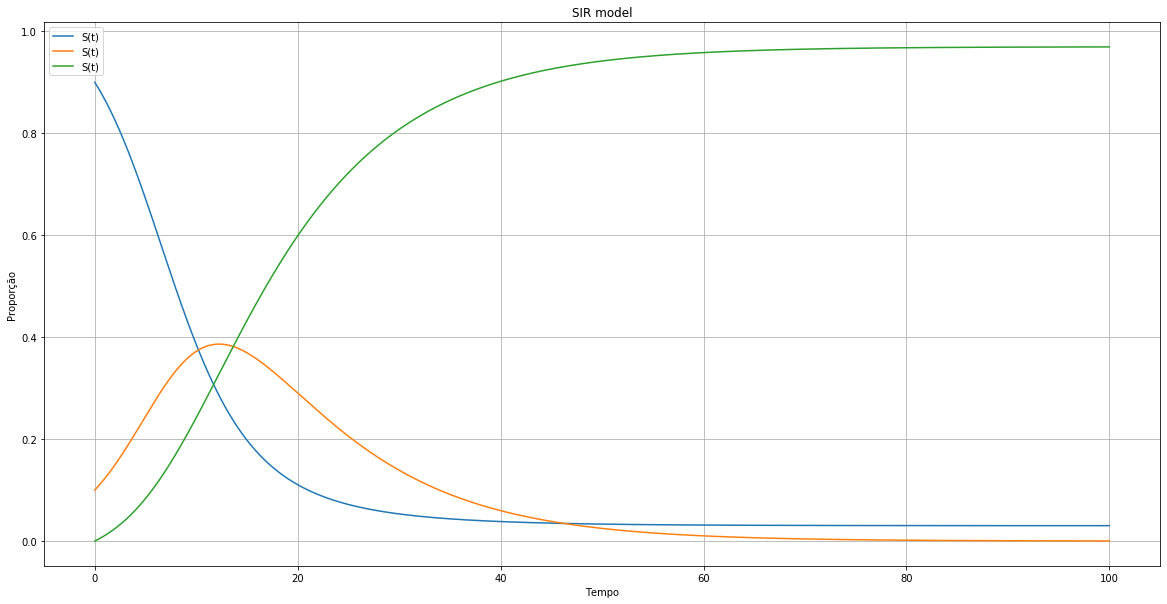

In [36]:

plt.figure(figsize=[20,10])
plt.plot(t, solucao[:, 0], label="S(t)")
plt.plot(t, solucao[:, 1], label="S(t)")
plt.plot(t, solucao[:, 2], label="S(t)")
plt.grid()
plt.legend()
plt.xlabel("Tempo")
plt.ylabel("Proporção")
plt.title("SIR model")

plt.show()

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from datetime import datetime as dt
from IPython.display import HTML

In [55]:

df = dadoslimpo.copy()
df['data'] = df['data'].apply(lambda x: pd.Timestamp(x).strftime('%d-%m-%Y'))
df['data'] = pd.to_datetime(df['data'], format='%d-%m-%Y')
df['data'] = df['data'].dt.normalize()


In [47]:
current_year = '05-05-2020'
dff = (df[df['data'].eq(current_year)]
       .sort_values(by='casosAcumulados', ascending=True)
       .head(27))


In [48]:
#fig, ax = plt.subplots(figsize=(15, 8))
#ax.barh(dff['sigla'], dff['casosAcumulados'])

In [101]:
import matplotlib.pyplot as plt
import random
#cores estaticas
colors = dict(zip(
   ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO', 'MA', 'PI', 'CE', 'RN',
       'PB', 'PE', 'AL', 'SE', 'BA', 'MG', 'ES', 'RJ', 'SP', 'PR', 'SC',
       'RS', 'MS', 'MT', 'GO', 'DF'],
['#93F569',
 '#81734D',
 '#0894BF',
 '#7F24FD',
 '#5F98BA',
 '#F98360',
 '#64EFCA',
 '#1A335F',
 '#DE79DF',
 '#12634D',
 '#08D7F2',
 '#757428',
 '#D2DBDF',
 '#6F1DA8',
 '#697F99',
 '#F8F175',
 '#E20361',
 '#22EBE1',
 '#015E63',
 '#B23883',
 '#DBCBE3',
 '#02B533',
 '#B3391D',
 '#B3391D',
 '#C0EF60',
 '#F5CA07',
 '#FCBD03']
))
#cores aleatórias
#number_of_colors = 27

#colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#             for i in range(number_of_colors)]
group_lk = df.set_index('data')['casosAcumulados'].to_dict()


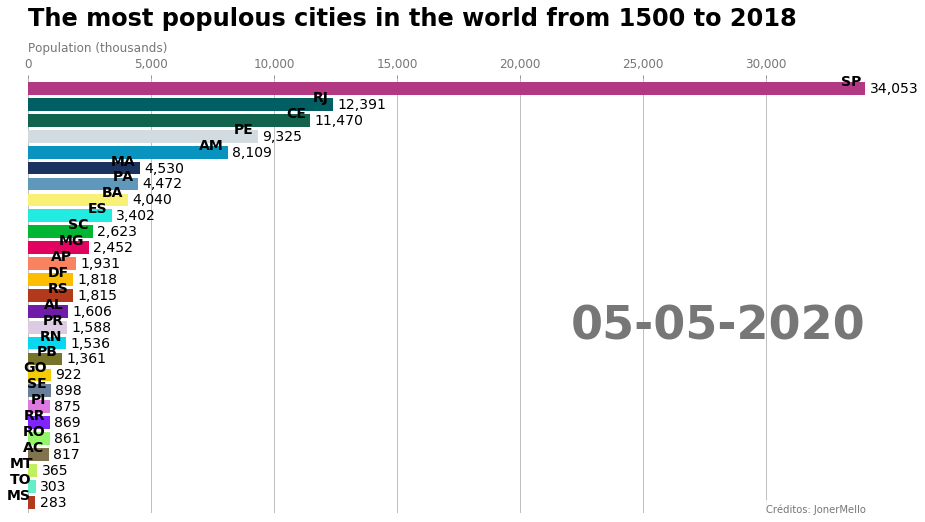

In [107]:
current_date = '05-05-2020'
fig, ax = plt.subplots(figsize=(15, 8))
def draw_barchart(date):
    dff = df[df['data'].eq(date)].sort_values(by='casosAcumulados', ascending=True).tail(27)
    ax.clear()
    ax.barh(dff['sigla'], dff['casosAcumulados'], color=[colors[x] for x in dff['sigla']])
    dx = dff['casosAcumulados'].max() / 200
    for i, (value, name) in enumerate(zip(dff['casosAcumulados'], dff['sigla'])):
        ax.text(value-dx, i,     name,           size=14, weight=600, ha='right', va='bottom')
       # ax.text(value-dx, i, group_lk[name], size=10, color='#444444', ha='right', va='baseline')
        ax.text(value+dx, i,     f'{value:,.0f}',  size=14, ha='left',  va='center')
    # ... polished styles
    ax.text(1, 0.4, date, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)
    ax.text(0, 1.06, 'Population (thousands)', transform=ax.transAxes, size=12, color='#777777')
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_ticks_position('top')
    ax.tick_params(axis='x', colors='#777777', labelsize=12)
    ax.set_yticks([])
    ax.margins(0, 0.01)
    ax.grid(which='major', axis='x', linestyle='-')
    ax.set_axisbelow(True)
    ax.text(0, 1.12, 'The most populous cities in the world from 1500 to 2018',
            transform=ax.transAxes, size=24, weight=600, ha='left')
    ax.text(1, 0, 'Créditos: JonerMello', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
    
draw_barchart(current_date)

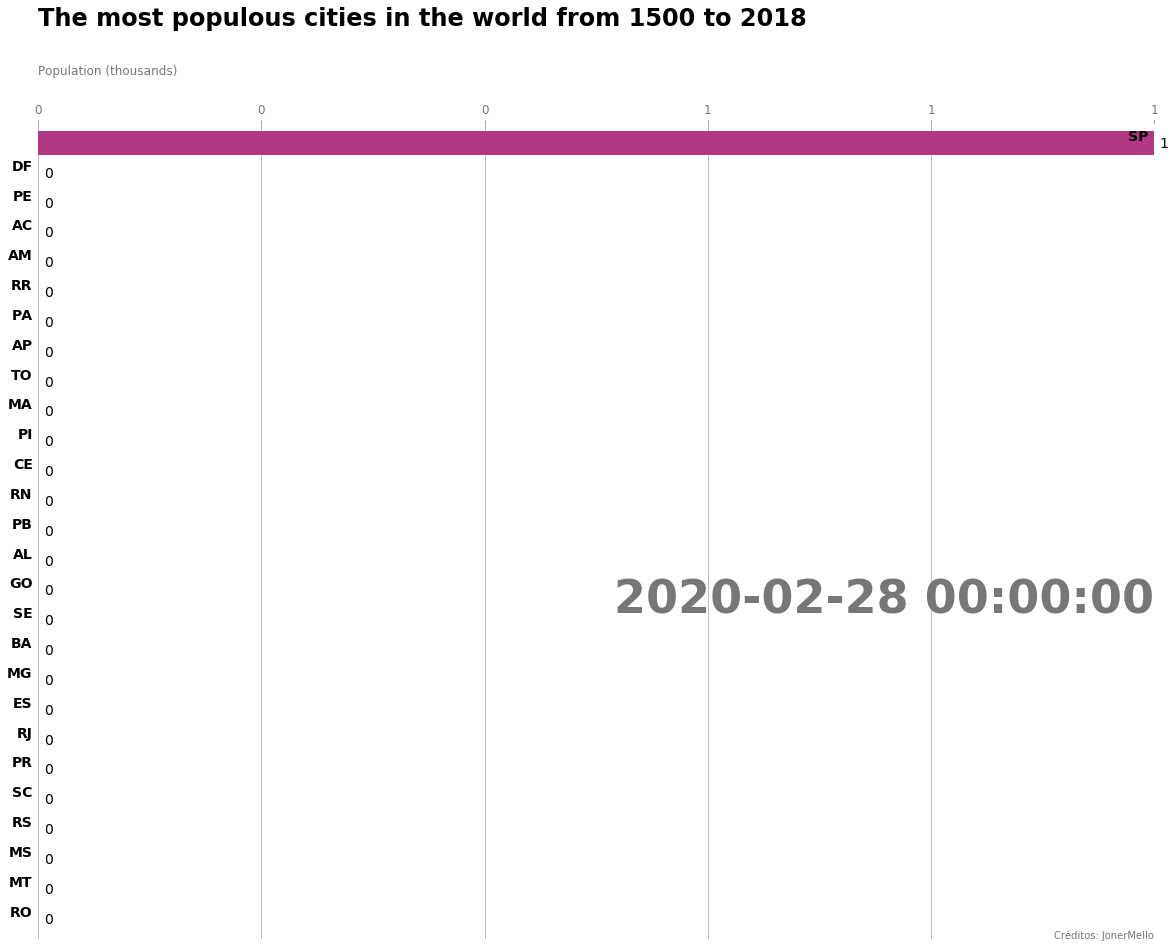

In [108]:
import matplotlib.animation as animation
from IPython.display import HTML
with plt.xkcd():
    fig, ax = plt.subplots(figsize=(20, 15))
    animator = animation.FuncAnimation(fig, draw_barchart, frames=pd.date_range(start='2020-02-28', end='2020-05-06'))
#HTML(animator.to_jshtml())
mywriter = animation.FFMpegWriter(fps=3)
animator.save('covid-19BR.mp4', writer=mywriter)
# or use animator.to_html5_video() or animator.save()

In [92]:
dff['sigla'].values

array(['MS', 'TO', 'MT', 'AC', 'RO', 'RR', 'PI', 'SE', 'GO', 'PB', 'RN',
       'PR', 'AL', 'RS', 'DF', 'AP', 'MG', 'SC', 'ES', 'BA', 'PA', 'MA',
       'AM', 'PE', 'CE', 'RJ', 'SP'], dtype=object)